<a href="https://colab.research.google.com/github/Dsbaule/Sketch2AIA/blob/master/Sketch2AIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## STEP 0. Configure runtime to work with GPU

We want to use the **12GB-RAM GPU** hardware acceleration!

Go to **> Menu > Runtime > Configure Runtime Type** And select **GPU** From the **Hardware accelerator** drop down meu

## STEP 1. Copy files to Google Drive
The necessary *darknet* folder can be downloaded from my [Google Drive](https://drive.google.com/drive/folders/1lGv3svGiI9LVwLOc4PPOOH--wZEF0d4M?usp=sharing).

Upload the folder to your Google Drive root.

## STEP 2. Connect the Colab notebook to Google Drive

Now we're gonna map your Google Drive folder. This first step is the only one that will require your manual interaction every time you run your notebook.

* Execute the following cell _(Click on Play button or press CTRL + ENTER)_ and click on the link to authorize your notebook to access to your Google Drive. 
* Paste the code Google will give to you and push `enter`

In [2]:
# This cell imports the drive library and mounts your Google Drive as a VM local drive. You can access to your Drive files 
# using this path "/content/gdrive/My Drive/"

from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

## STEP 3.A Check CUDA release version

Nvidia CUDA is pre-installed on Colab notebooks. Now we'll check the version installed.

> _**BE AWARE:** Maybe some time from the time I'm writing these lines (April 9th, 2019)  the CUDA version is upgraded on Colab and you should download another version of the cuDNN in the next step. Now is release 10.1 and we are using cuDNN (cudnn-10.0-linux-x64-v7.6.5.32.tgz) accordingly_

In [ ]:
# This cell can be commented once you checked the current CUDA version
# CUDA: Let's check that Nvidia CUDA is already pre-installed and which version is it. In some time from now maybe you 
!/usr/local/cuda/bin/nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


## STEP 3.B Install cuDNN according to the current CUDA version
Now, you need to download cuDNN from Nvidia web site. You'll need to sign up on the site. If the file is already on the darknet folder, you can skip the followning instructions and just run the cell bellow.

* If the file is not in your Google Drive, Download cuDNN from [Nvidia website](https://developer.nvidia.com/cudnn) 

  * Right now, because we have _**CUDA 10.1**_ preinstalled in Colab runtime, you need download [cuDNN v7.6.5.32 for CUDA v10.0](https://developer.nvidia.com/compute/machine-learning/cudnn/secure/7.6.5.32/Production/10.1_20191031/cudnn-10.1-linux-x64-v7.6.5.32.tgz) - the file is cudnn-10.0-linux-x64-v7.6.5.32.tgz

* On your Google Drive folder, create a folder named _**cuDNN**_ in your _**darknet**_ folder. Copy the _**tgz**_ file there 

In [ ]:
# We're unzipping the cuDNN files from your Drive folder directly to the VM CUDA folders
!tar -xzvf gdrive/My\ Drive/darknet/cuDNN/cudnn-10.0-linux-x64-v7.6.5.32.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

# Now we check the version we already installed. Can comment this line on future runs
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.6.5
cuda/lib64/libcudnn_static.a
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 6
#define CUDNN_PATCHLEVEL 5
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


## STEP 4. Installing Darknet
Great!! We have all the necessary to start working with Darknet. 

This notebook works with a slightly modified version of darknet, which is based on the [AlexeyAB Darknet repo](https://github.com/AlexeyAB/darknet/)
The changes applied to the original repo are:
* Allowing to use spaces on the darknet configuration files _**obj.data**_. Necessary to work with Google Drive directly.
* Removing some logs on every epoch. The original repo write more logs than the Colab notebook can sync. This creates a long queue during the training. This version only shows the results after every iteration.

You can take a look to the code at the [github repo](https://github.com/kriyeng/darknet/)

## STEP 4-A. Cloning and compiling Darkent.
In this step we'll clone the darkent repo and compile it. 
* Clone Repo
* Compile Darknet

When compiling ends, your output last line has to be something like this:

`g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV 'pkg-config--cflags opencv' -DGPU (...)`

In [ ]:
# Leave this code uncommented on the very first run of your notebook or if you ever need to recompile darknet again.
# Comment this code on the future runs.
!git clone https://github.com/kriyeng/darknet/
%cd darknet

# Check the folder
!ls

# I have a branch where I have done the changes commented above
!git checkout feature/google-colab

Cloning into 'darknet'...
remote: Enumerating objects: 10068, done.
remote: Total 10068 (delta 0), reused 0 (delta 0), pack-reused 10068
Receiving objects: 100% (10068/10068), 9.94 MiB | 4.16 MiB/s, done.
Resolving deltas: 100% (6758/6758), done.
/content/darknet
3rdparty      CMakeLists.txt	      image_yolov3.sh	     scripts
appveyor.yml  CMakeSettings.json      include		     src
build	      DarknetConfig.cmake.in  json_mjpeg_streams.sh  video_v2.sh
build.ps1     darknet.py	      LICENSE		     video_yolov3.sh
build.sh      darknet_video.py	      Makefile
cfg	      data		      net_cam_v3.sh
cmake	      image_yolov2.sh	      README.md
Branch 'feature/google-colab' set up to track remote branch 'feature/google-colab' from 'origin'.
Switched to a new branch 'feature/google-colab'


If you plan on using Darknet inside a python program, change the makefile before compiling.

In [ ]:
#Replace the original makefile with the one from Google Drive
!cd /content/darknet
!cp '/content/gdrive/My Drive/darknet/Makefile' '/content/darknet/Makefile'

In [ ]:
#Compile Darknet
!make

mkdir -p obj
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(mat_cv*, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:896:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -fPIC -c ./src/http_stream.cpp -o obj/http_stream.o
./src/http_stream.cpp: In member function ‘boo

## STEP 5. Runtime configuration finished!
Let's chek it out!

If you are running this notebook for the first time, you can run the following cells in order to check if everything goes as expected!

## Some Utils
Let's add some utils that maybe can be useful.

These utils are:
* imgShow() - Will help us to show an image in the remote VM
* download() - Will allow you to get some file from your notebook in case you need to
* upload() - You can upload files to your current folder on the remote VM.

Thanks to [Ivan Goncharov](https://twitter.com/Ivangrov) for these helpers!

In [ ]:
#download files
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
  
  
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)
def download(path):
  from google.colab import files
  files.download(path)

# PART 2. Training YOLO

 > _**TRICK:** Every time you want to run all your cells automatically you can go to the **> Menu > Runtime > run all**. Maybe you don't want to execute the entire notebook. You can write the following cell where you want to stop the process and uncoment the **`assert False`** command. This will throw an error and will stop to run more cells. Thanks to: [This thread](https://groups.google.com/forum/#!topic/jupyter/ELftSFSiedQ)_




In [ ]:
# don't go beyond here with Run All
assert False

AssertionError: ignored

Copying cfg into drive for modifications (To create a new CFG file):

In [ ]:
#!cp "/content/darknet/cfg/yolov3.cfg" "/content/gdrive/My Drive/darknet/cfg/"

When you execute the following command, your model will start training.

You will have a log line per epoch. On each iteration you will see how your training is going.

> **TRICK: Darknet copies a backup of your trained weights every 100 iterations. As magic, this file will be synced to your local drive on your computer, as well as the backups darknet do every 1000 iterations, saving it on a separate file.**

In [ ]:
#Download the weights for the convolutional layers
!wget -O /content/darknet/darknet53.conv.74 https://pjreddie.com/media/files/darknet53.conv.74

In [ ]:
# Train starting from the Downloaded weights
!./darknet detector train "/content/gdrive/My Drive/darknet/obj.data" "/content/gdrive/My Drive/darknet/cfg/NewDatasetYolov3.cfg" "/content/darknet/darknet53.conv.74" -dont_show

To continue training from where you left off, use the following cell:

In [ ]:
#Google drive doesn't seem to like the file for the convolutional layers' weights, so i'm using this:
!./darknet detector train "/content/gdrive/My Drive/darknet/obj.data" "/content/gdrive/My Drive/darknet/cfg/NewDatasetYolov3.cfg" "/content/gdrive/My Drive/darknet/backup/NewDatasetYolov3_last.weights" -dont_show 

## Testing the model

To test detection with an image, use the following cells:

In [ ]:
#!Replace the coco classes with your custom ones.
!cp "/content/gdrive/My Drive/darknet/obj.names" "/content/darknet/data/coco.names"

In [ ]:
# Execute darknet using YOLOv3 model with pre-trained weights to detect objects on 'person.jpg'
!./darknet detect "/content/gdrive/My Drive/darknet/cfg/NewDatasetYolov3.cfg" "/content/gdrive/My Drive/darknet/backup/NewDatasetYolov3_18000.weights" "/content/gdrive/My Drive/darknet/TestImg/NewLoginInterfaceScan.jpg" -dont-show

# Show the result using the helper imgShow()
imShow('predictions.jpg')

AttributeError: ignored

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
  14 c

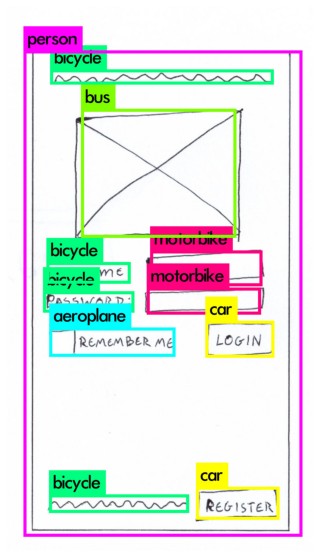

In [ ]:
# Execute darknet using YOLOv3 model with pre-trained weights to detect objects on 'person.jpg'
!./darknet detect "/content/gdrive/My Drive/darknet/cfg/NewDatasetYolov3.cfg" "/content/gdrive/My Drive/darknet/backup/NewDatasetYolov3_18000.weights" "/content/gdrive/My Drive/darknet/TestImg/NewLoginInterfaceScan.jpg" -dont-show

# Show the result using the helper imgShow()
imShow('predictions.jpg')
#/content/gdrive/My Drive/darknet/obj.data

In [ ]:
# Execute darknet using YOLOv3 model with pre-trained weights to detect objects on 'person.jpg'
!./darknet detect "/content/gdrive/My Drive/darknet/cfg/NewDatasetYolov3.cfg" "/content/gdrive/My Drive/darknet/backup/NewDatasetYolov3_18000.weights" -ext_output "/content/gdrive/My Drive/darknet/TestImg/20200324_010335.jpg" -dont-show

# Print the resulting bounding boxes


layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
  14 c

# Obtaining Mean Average Precision (MaP) and Intersect over Union (IoU):

* mAP (mean average precision) - mean value of average precisions for each class, where average precision is average value of 11 points on PR-curve for each possible threshold (each probability of detection) for the same class (Precision-Recall in terms of PascalVOC, where Precision=TP/(TP+FP) and Recall=TP/(TP+FN) ), page-11: http://homepages.inf.ed.ac.uk/ckiw/postscript/ijcv_voc09.pdf

* IoU (intersect over union) - average instersect over union of objects and detections for a certain threshold = 0.24

In [ ]:
!./darknet detector map "/content/gdrive/My Drive/darknet/obj.data" "/content/gdrive/My Drive/darknet/cfg/yolov3.cfg" "/content/gdrive/My Drive/darknet/backup/NewDatasetYolov3_18000.weights" -dont_show 

## Using darknet inside a python program

Attempting to print the bounding boxes obtained from darknet inside a python program.

In order to use the Python3 Wrapper for Darknet, you need to recompile it with the flag `LIBSO=1` set in the makefile.



In [ ]:
import sys
sys.path.append('/content/darknet')

In [ ]:
import darknet

'''
Convenience function to handle the detection and returns of objects.
    Displaying bounding boxes requires libraries scikit-image and numpy
    Parameters
    ----------------
    imagePath: str
        Path to the image to evaluate. Raises ValueError if not found
    thresh: float (default= 0.25)
        The detection threshold
    configPath: str
        Path to the configuration file. Raises ValueError if not found
    weightPath: str
        Path to the weights file. Raises ValueError if not found
    metaPath: str
        Path to the data file. Raises ValueError if not found
    showImage: bool (default= True)
        Compute (and show) bounding boxes. Changes return.
    makeImageOnly: bool (default= False)
        If showImage is True, this won't actually *show* the image, but will create the array and return it.
    initOnly: bool (default= False)
        Only initialize globals. Don't actually run a prediction.
    Returns
    ----------------------
    When showImage is False, list of tuples like
        ('obj_label', confidence, (bounding_box_x_px, bounding_box_y_px, bounding_box_width_px, bounding_box_height_px))
        The X and Y coordinates are from the center of the bounding box. Subtract half the width or height to get the lower corner.
    Otherwise, a dict with
        {
            "detections": as above
            "image": a numpy array representing an image, compatible with scikit-image
            "caption": an image caption
        }
'''
results = darknet.performDetect(
    imagePath="/content/gdrive/My Drive/darknet/TestImg/NewLoginInterfaceScan.jpg",
    thresh=0.1,
    configPath="/content/gdrive/My Drive/darknet/cfg/yolov3.cfg",
    weightPath="/content/gdrive/My Drive/darknet/backup/NewDatasetYolov3_18000.weights",
    metaPath="/content/gdrive/My Drive/darknet/obj.data",
    showImage=False,
    makeImageOnly=False,
    initOnly=False)

for detectedObject in results:
  print('Object: ' + str(detectedObject[0])[1:])
  print('\tConfidence: ' + str(detectedObject[1]))
  print('\t\tCenter X: ' + str(detectedObject[2][0]))
  print('\t\tCenter Y: ' + str(detectedObject[2][1]))
  print('\t\tCenter X: ' + str(detectedObject[2][2]))
  print('\t\tCenter Y: ' + str(detectedObject[2][3]))


AttributeError: ignored

## SOURCES

* This notebook is heavely based on The David Ibáñez [notebook](https://github.com/kriyeng/yolo-on-colab-notebook/blob/master/Tutorial_DarknetToColab.ipynb)
* YOLO original web site [Joseph Redmon Page](https://pjreddie.com/darknet/yolo/)
* AlexeyAB darknet repo [github](https://github.com/AlexeyAB/darknet/)
* The Ivan Goncharov [notebook](https://github.com/ivangrov/YOLOv3-GoogleColab/blob/master/YOLOv3_GoogleColab.ipynb).